In [1]:
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
from tqdm import tqdm
from dataclasses import dataclass
from itertools import product, chain
import torch 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
ds = MNIST(
    './data/train',
    True,
    lambda img: torch.Tensor(np.asarray(img).flatten())/256,
    lambda y: torch.Tensor([1 if i==y else 0 for i in range(10)]),
    download=False
)
ds_test = MNIST(
    './data/test',
    False,
    lambda img: torch.Tensor(np.asarray(img).flatten())/256,
    lambda y: torch.Tensor([1 if i==y else 0 for i in range(10)]),
    download=False
)
ds_train = Subset(ds, range(0, 2048))
ds_val = Subset(ds, range(2048, 2048+512+1))
batch_size = 128
train_data = DataLoader(ds_train, batch_size, True, drop_last=True)
test_data = DataLoader(ds_test, batch_size, False)
val_data = DataLoader(ds_val, batch_size, False)

In [3]:
@dataclass
class HyperParams:
    layers_num: int 
    first_params_num: int 
    weight_decay: float
    def __init__(self, layers_num, first_params_num, weight_decay):
        layers_num = int(layers_num)
        first_params_num = int(first_params_num)
        assert 2 <= layers_num <= 10
        assert 10 <= first_params_num <= 8192
        assert 0.0001 <= weight_decay <= 0.1
        self.layers_num = layers_num
        self.first_params_num = first_params_num
        self.weight_decay = weight_decay
    def vectorize(self):
        return np.array([self.layers_num, self.first_params_num, self.weight_decay])


In [4]:
class Model:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        initial_size = 784
        final_size = 10
        step = int((self.hyper_params.first_params_num-final_size)/(self.hyper_params.layers_num-1))
        layers = [torch.nn.Linear(initial_size, self.hyper_params.first_params_num), torch.nn.GELU()]
        prev_size = self.hyper_params.first_params_num
        for _ in range(1, self.hyper_params.layers_num-1):
            layers.append(torch.nn.Linear(prev_size, prev_size-step))
            layers.append(torch.nn.GELU())
            prev_size = prev_size-step
        layers.append(torch.nn.Linear(prev_size, final_size))
        layers.append(torch.nn.GELU())
        self.__model = torch.nn.Sequential(*layers)
        self.__optim = torch.optim.AdamW(self.__model.parameters(), weight_decay=self.hyper_params.weight_decay)
        self.__loss_func = torch.nn.CrossEntropyLoss()
        self.epochs = 16
    def __repr__(self):
        return str(self.hyper_params)
    def train(self, data_loader):
        losses = []
        for i in range(1, self.epochs+1):
            for img, target in data_loader:
                preds = self.__model(img)
                loss = self.__loss_func(preds, target)
                self.__optim.zero_grad()
                loss.backward()
                self.__optim.step()
                losses.append(loss.item())
        return np.mean(losses)
    def val(self, data_loader):
        acc = 0
        counter = 0
        for img, target in data_loader:
            preds = self.__model(img)
            answer = torch.nn.functional.softmax(preds.detach()).numpy().argmax(1) == target.numpy().argmax(1)
            acc += answer.mean()
            counter+=1
        return acc/counter
    



In [5]:
class Evolution:
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
        init_layers_num = [3, 5, 9]
        init_first_params_num = [1024, 256, 2048]
        init_weight_decay = [0.01, 0.001, 0.0001]
        self.models = []
        
        for layers_num, first_params_num, weight_decay in product(init_layers_num, init_first_params_num, init_weight_decay):
            self.models.append(Model(HyperParams(layers_num, first_params_num, weight_decay)))
        self.population_len = len(self.models)
        self.MUTAGENS = [[3, 10], [128, 4096], [0.0001, 0.01]]
    def train(self):
        losses = []
        print("Train models")
        for model in tqdm(self.models):
            losses.append(model.train(self.train_data))
        print("Train losses: ",losses)
    def gen_table(self):
        table = pd.DataFrame({'model': self.models})
        table['val'] = table.model.map(lambda model: model.val(self.test_data))
        table['norm_val'] = table.val / table.val.sum()
        table['norm_val'] /= table.norm_val.sum()
        return table.sort_values(by=['val'], axis=0, ascending=True)
    def selection(self):
        self.models = list(np.random.choice(self.table.model, size=self.population_len, p=self.table.norm_val))
    def crossing_over(self):
        def cross(parent1, parent2):
            pc = 0.7
            genes1, genes2 = parent1.hyper_params.vectorize(), parent2.hyper_params.vectorize()
            while True:
                try:
                    new_genes1, new_genes2 = [], []
                    for gen1, gen2 in zip(genes1, genes2):
                        if np.random.random() < pc:
                            new_genes1.append(gen1)
                            new_genes2.append(gen2)
                        else:
                            rand = np.random.random()
                            new_genes1.append(gen1*rand+(1-rand)*gen2)
                            new_genes2.append(gen2*rand+(1-rand)*gen1)
                    hyper_params1 = HyperParams(*new_genes1)
                    hyper_params2 = HyperParams(*new_genes2)
                except AssertionError:
                    continue
                else:
                    return Model(hyper_params1), Model(hyper_params2)
        np.random.shuffle(self.models)
        pairs = [tuple(self.models[-2:])]
        pairs += [tuple(self.models[i:i+2]) for i in range(0, len(self.models)-1, 2)]
        self.models = list(chain(*map(lambda pair: cross(*pair), pairs)))[:self.population_len]
    def mutation(self):
        pm = 0.4
        def mutate(model):
            if np.random.random() > pm:
                return model 
            else:
                gen = model.hyper_params.vectorize()
                index = np.random.randint(0, len(gen))
                gen[index] = np.random.uniform(*self.MUTAGENS[index])
                try:
                    return Model(HyperParams(*gen))
                except AssertionError:
                    return model 
        self.models = list(map(lambda model: mutate(model), self.models))
    def replace_new_gen(self):
        new_table = self.gen_table()
        con_table = pd.concat([self.table, new_table], axis=0)
        con_table.sort_values(['val'], ascending=True, inplace=True)
        self.table = con_table.tail(self.population_len)
        self.table.norm_val = self.table.val / self.table.val.sum()
    def evolve(self, N):
        best = []
        self.train()
        self.table = self.gen_table()
        for i in range(1, N+1):
            print(f"Generation {i} of {N}")
            self.selection()
            self.crossing_over()
            self.mutation()
            self.train()
            self.replace_new_gen()
            best.append(self.table.iloc[-1].val)
            print(self.table)
        best_row = self.table['val'].idxmax()
        return self.table.iloc[best_row].model, self.table.iloc[best_row].val, best
            





In [ ]:
def save_plot(x, name, labels):
    plt.figure(figsize=(10, 7))
    plt.plot(
        x, linestyle='-', 
        label=labels
    )
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.legend()
    plt.savefig(f"{name}.png")

In [7]:
evolution = Evolution(train_data, test_data)
model, acc, accs = evolution.evolve(10)


Train models


100%|██████████| 27/27 [01:56<00:00,  4.31s/it]


Train losses:  [np.float64(0.1992116549226921), np.float64(0.19768667625794478), np.float64(0.2055876703825561), np.float64(0.3390054589617648), np.float64(0.34752479918824974), np.float64(0.33705224431469105), np.float64(0.15425239912087818), np.float64(0.15723072934065385), np.float64(0.15693583116399168), np.float64(0.265989105349945), np.float64(0.278131655281868), np.float64(0.24555420607975975), np.float64(0.4104955371003598), np.float64(0.4055898745136801), np.float64(0.42612865351111395), np.float64(0.22301764482836006), np.float64(0.2464923445986642), np.float64(0.2218096906426581), np.float64(0.5998965878097806), np.float64(0.5624736043391749), np.float64(0.5642793603183236), np.float64(0.7708161959890276), np.float64(0.7844686924072448), np.float64(0.6799185428535566), np.float64(0.5485098164353985), np.float64(0.594111012731446), np.float64(0.617299477889901)]
Generation 1 of 10
Train models


100%|██████████| 27/27 [01:46<00:00,  3.93s/it]


Train losses:  [np.float64(0.2446374727978764), np.float64(0.19990782668628526), np.float64(0.15387685883865743), np.float64(0.25655682807337143), np.float64(0.18555815188392444), np.float64(0.3472732563459431), np.float64(0.2525823961905189), np.float64(0.8236343011376448), np.float64(0.18370253403008974), np.float64(0.38206968694430543), np.float64(0.5589808358054142), np.float64(0.7573227597749792), np.float64(0.34367380080220755), np.float64(0.15595833483052957), np.float64(0.7875163514108863), np.float64(0.2603067332261162), np.float64(0.3484501994244056), np.float64(0.5712122973200167), np.float64(0.15158564163834853), np.float64(0.20154150999587728), np.float64(0.5547617148331483), np.float64(0.20287519880002947), np.float64(0.3771088094508741), np.float64(0.36754384064261103), np.float64(0.16263016140783293), np.float64(0.7098940994765144), np.float64(0.2474769422533427)]
                                                model       val  norm_val
3   HyperParams(layers_num=3, fir

100%|██████████| 27/27 [01:44<00:00,  3.85s/it]


Train losses:  [np.float64(0.20412057552312035), np.float64(0.2045805603993358), np.float64(0.2832622721689404), np.float64(0.16948460987737235), np.float64(0.2031054810177011), np.float64(0.15903565920439178), np.float64(0.27133099272396066), np.float64(0.2325279695687641), np.float64(0.3411135187106993), np.float64(0.2950516052696912), np.float64(0.21578534020636653), np.float64(0.34077173567493446), np.float64(0.26441954559595615), np.float64(0.5347974577816785), np.float64(0.33519314845034387), np.float64(0.19485153452478698), np.float64(0.20174517817667947), np.float64(0.19790455076417857), np.float64(0.43825750252290163), np.float64(0.23480915537766123), np.float64(0.35278392577311024), np.float64(0.36212977061222773), np.float64(0.5677374318402144), np.float64(0.2020255321640434), np.float64(0.1556390156051748), np.float64(0.1905593967749155), np.float64(0.4204715449377545)]
                                                model       val  norm_val
15  HyperParams(layers_num=5, f

100%|██████████| 27/27 [01:55<00:00,  4.27s/it]


Train losses:  [np.float64(0.15712553420598852), np.float64(0.2010619277416481), np.float64(0.17858858207318917), np.float64(0.15708030670202788), np.float64(0.1579499859221869), np.float64(0.17881155789427794), np.float64(0.2035738250488066), np.float64(0.1513183999827561), np.float64(0.1530589296874041), np.float64(0.20325552662234259), np.float64(0.19415125252044163), np.float64(0.145102041867176), np.float64(0.1810459752832685), np.float64(0.15235508329533332), np.float64(0.23301039161390236), np.float64(0.3762506193052104), np.float64(0.2088940079729582), np.float64(0.15941205820490723), np.float64(0.1562031210742134), np.float64(0.21709181463847926), np.float64(0.1915780019498925), np.float64(0.1580797447504665), np.float64(0.1992438060033237), np.float64(0.20271261330253765), np.float64(0.18222753944769465), np.float64(0.1826938542890275), np.float64(0.22777838224556035)]
                                                model       val  norm_val
5   HyperParams(layers_num=3, firs

100%|██████████| 27/27 [01:56<00:00,  4.32s/it]


Train losses:  [np.float64(0.19754184290104604), np.float64(0.14880327619130185), np.float64(0.17595054918001551), np.float64(0.15419919012128958), np.float64(0.1615859126095529), np.float64(0.1909616575048858), np.float64(0.15148657342319893), np.float64(0.1482490623470767), np.float64(0.17757236911438667), np.float64(0.15836778331777168), np.float64(0.15028701229948638), np.float64(0.16301115666192345), np.float64(0.1940375411286368), np.float64(0.1815619548633549), np.float64(0.5387315080442932), np.float64(0.557471103806165), np.float64(0.20088183789084724), np.float64(0.18363493539663978), np.float64(0.15171593786840276), np.float64(0.13030678866221024), np.float64(0.1583813739780453), np.float64(0.15874069901337862), np.float64(0.15899662125571012), np.float64(0.28386013736235327), np.float64(0.15552572920933017), np.float64(0.15910340752361662), np.float64(0.21222339613814256)]
                                                model       val  norm_val
26  HyperParams(layers_num=5

100%|██████████| 27/27 [01:50<00:00,  4.11s/it]


Train losses:  [np.float64(0.15920212296759928), np.float64(0.1521600283515454), np.float64(0.19650393299070856), np.float64(0.18073358241690585), np.float64(0.35739175708658877), np.float64(0.17273957988982147), np.float64(0.12509798129144656), np.float64(0.2012314008698013), np.float64(0.16030048681841436), np.float64(0.20873175519864162), np.float64(0.20434613248926325), np.float64(0.25645147744307906), np.float64(0.11954677582150453), np.float64(0.14636681820070407), np.float64(0.21600994051004818), np.float64(0.20804920045520703), np.float64(0.2033119430179795), np.float64(0.16196711615566528), np.float64(0.18755369906648411), np.float64(0.1618800277142327), np.float64(0.1760192931610618), np.float64(0.16996787963489624), np.float64(0.16219887298393587), np.float64(0.1780871203445713), np.float64(0.20496707292477367), np.float64(0.1663525919946096), np.float64(0.11787553537863005)]
                                                model       val  norm_val
7   HyperParams(layers_num

100%|██████████| 27/27 [02:18<00:00,  5.14s/it]


Train losses:  [np.float64(0.16117092305967162), np.float64(0.18948968851054815), np.float64(0.19143896778859926), np.float64(0.14178581211558594), np.float64(0.1509344999562927), np.float64(0.14872485550495185), np.float64(0.15027466188075778), np.float64(0.15127423088233627), np.float64(0.15322078264443917), np.float64(0.15130896264054172), np.float64(0.1248899299621371), np.float64(0.19742414202482905), np.float64(0.15528645505355598), np.float64(0.2016111817856654), np.float64(0.15864050065647461), np.float64(0.16635768479955004), np.float64(0.1371748626693261), np.float64(0.3794621550332522), np.float64(0.19405516619644914), np.float64(0.1586174198369008), np.float64(0.15739114784400954), np.float64(0.1268104178179783), np.float64(0.1429764019940194), np.float64(0.15221037100286594), np.float64(0.14390569526131003), np.float64(0.12078077302328438), np.float64(0.1896770543526145)]
                                                model       val  norm_val
7   HyperParams(layers_num=3

100%|██████████| 27/27 [02:41<00:00,  5.97s/it]


Train losses:  [np.float64(0.15351162058959744), np.float64(0.13130568430347012), np.float64(0.15593409715347661), np.float64(0.2063653265913672), np.float64(0.4171716836935957), np.float64(0.13355819617231646), np.float64(0.15997284009699797), np.float64(0.15730939950162792), np.float64(0.1592890576539503), np.float64(0.13354991763185353), np.float64(0.1425287054535147), np.float64(0.15446012864867953), np.float64(0.1442115342820216), np.float64(0.11676574090381564), np.float64(0.16342547977774302), np.float64(0.16725112011476995), np.float64(0.16505869141019502), np.float64(0.12433682771256827), np.float64(0.1502012587829995), np.float64(0.1933868749783869), np.float64(0.1644127551380734), np.float64(0.4756981657119468), np.float64(0.14282718793060667), np.float64(0.18113723891383415), np.float64(0.288470202965982), np.float64(0.17688559559792338), np.float64(0.15790776694939268)]
                                                model       val  norm_val
15  HyperParams(layers_num=3, 

100%|██████████| 27/27 [03:51<00:00,  8.59s/it]


Train losses:  [np.float64(0.1369980665303956), np.float64(0.11904965547728352), np.float64(0.15760736073048065), np.float64(0.15919613546066103), np.float64(0.14235404824853504), np.float64(0.13999063606934214), np.float64(0.13806207730419828), np.float64(0.15575908552796136), np.float64(0.14360566000800645), np.float64(0.15371567214128845), np.float64(0.1333871002043452), np.float64(0.13066344395838314), np.float64(0.12518131967112822), np.float64(0.5674985542718787), np.float64(0.13800944666854775), np.float64(0.15466319887377722), np.float64(0.14046745325026677), np.float64(0.16407546033769904), np.float64(0.12998778030373614), np.float64(0.13892846330236353), np.float64(0.25487577421881724), np.float64(0.13372807844598356), np.float64(0.38861313297820743), np.float64(0.14585699065855806), np.float64(0.15104450298122174), np.float64(0.14157035866992373), np.float64(0.13878061384662033)]
                                                model       val  norm_val
1   HyperParams(layers

100%|██████████| 27/27 [03:22<00:00,  7.49s/it]


Train losses:  [np.float64(0.1634766661586582), np.float64(0.18818430014562182), np.float64(0.16237462555955062), np.float64(0.1586947650566799), np.float64(0.14282712464023462), np.float64(0.12504631268689081), np.float64(0.35090014222441823), np.float64(0.24567623178336362), np.float64(0.12650477031525043), np.float64(0.19639572594678611), np.float64(0.16211138372091227), np.float64(0.1896388652485257), np.float64(0.13253382929019608), np.float64(0.21230349623328948), np.float64(0.12988156438132137), np.float64(0.15554684662038198), np.float64(0.1994443789772049), np.float64(0.12368489920049797), np.float64(0.1420783314140408), np.float64(0.1591425611068189), np.float64(0.22956041823272244), np.float64(0.12873708151505525), np.float64(0.16561463690140954), np.float64(0.15891604267335424), np.float64(0.13222059533222819), np.float64(0.1582939337777134), np.float64(0.5975675203226274)]
                                                model       val  norm_val
21  HyperParams(layers_num=

100%|██████████| 27/27 [03:14<00:00,  7.22s/it]


Train losses:  [np.float64(0.1571340402565511), np.float64(0.14592945914728261), np.float64(0.15208454501521373), np.float64(0.15288266806783213), np.float64(0.15315445148758045), np.float64(0.15830146560938374), np.float64(0.18646716730199842), np.float64(0.15941480765923188), np.float64(0.1272789766103415), np.float64(0.137125563466725), np.float64(0.18102069695487444), np.float64(0.1652586695199716), np.float64(0.12978535651768652), np.float64(0.3443148758888128), np.float64(0.1624809455815921), np.float64(0.13609091305511356), np.float64(0.1378339708680869), np.float64(0.24379840064830205), np.float64(0.23252372007118538), np.float64(0.14330747947883538), np.float64(0.512957702667336), np.float64(0.1440695439650881), np.float64(0.12410851855895544), np.float64(0.13369822473100612), np.float64(0.19444372780708363), np.float64(0.1248019937834215), np.float64(0.12643525903149566)]
                                                model       val  norm_val
3   HyperParams(layers_num=3, f

HyperParams(layers_num=3, first_params_num=2387, weight_decay=np.float64(0.008825495169404996))


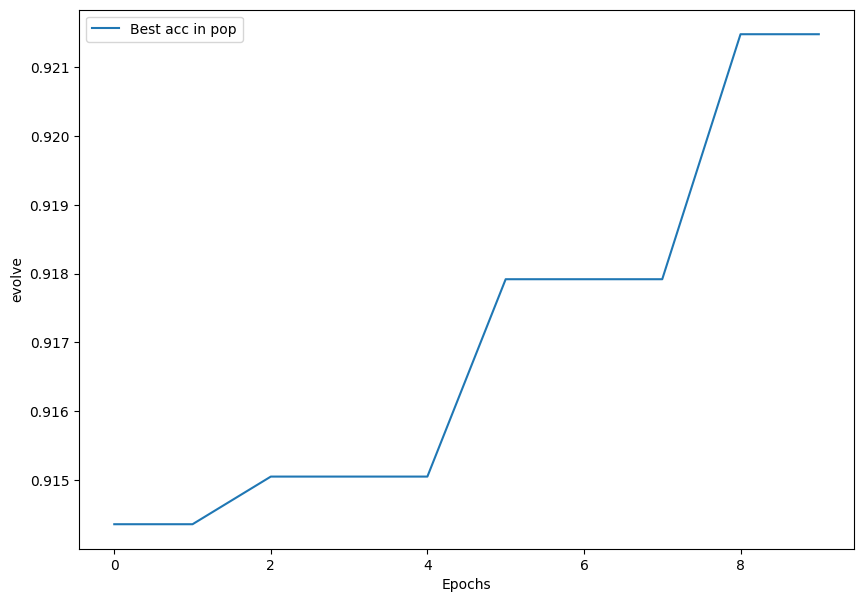

In [8]:
print(model)
save_plot(accs, 'evolve', "Best acc in pop")